In [1]:
#ICA Demonstration

In [2]:
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import genfromtxt
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
from sklearn.preprocessing import normalize
from numpy.matlib import repmat
from os.path import dirname, join as pjoin
import scipy.io as sio

Here, we load in our sample datasets. We are using _____ from ____.

In [3]:
mat = sio.loadmat('S02_restingPre_EC.mat')
data = mat["dataRest"]
datatransp = data.T
my_data_closed = np.delete(datatransp,np.s_[65:68], axis=1)

mat = sio.loadmat('S02_restingPre_EO.mat')
data = mat["dataRest"]
datatransp = data.T
my_data_open = np.delete(datatransp,np.s_[65:68], axis=1)

In [4]:
means_open = np.mean(my_data_open, axis=1, keepdims = True)
means_closed = np.mean(my_data_closed, axis=1, keepdims = True)

#zero means and transpose matrix
zeroed_data_open = my_data_open - np.matlib.repmat(means_open, 1, 65)#15)
zeroed_data_open = zeroed_data_open[:15000, :5]

zeroed_data_closed = my_data_closed - np.matlib.repmat(means_closed, 1, 65)#15)
zeroed_data_closed = zeroed_data_closed[:15000, :5]

print(zeroed_data_open.shape)
print(zeroed_data_closed.shape)

(15000, 5)
(15000, 5)


In [5]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

In [6]:
def PCA(zeroed_data):
    D, V = np.linalg.eig(zeroed_data.transpose()@zeroed_data)
    V, D = eigsort(V, D)

    U = zeroed_data@V
    U = normalize(U, norm='l2', axis=0)
    reconstructed_dataset = U.T @ zeroed_data[:,:]
    reconstructed = U[:,:]@np.array((reconstructed_dataset[:][:]))
#     reconstructed = U[:,:10]@np.array((reconstructed_dataset[:10][:]))
    
    return U
    return reconstructed


In [7]:
reconstructed_open = PCA(zeroed_data_open)
reconstructed_closed = PCA(zeroed_data_closed)

In [8]:
def g(x):
    return np.tanh(x)

#g'(x) = 1-tanh^2(x)
def g_der(x):
    return 1 - np.tanh(x) ** 2

def scale(X):
    #For decorrelated mixture signals projected to PCA space as U = VD
    #Z =(λ^(-1/2))U = (λ^(-1/2))VD
    pass

def recalculate_w(w, X):
    w_new = (X * g(w.T@X)).mean(axis=1) - g_der(w.T@X).mean() * w    
    w_new /= np.sqrt((w_new ** 2).sum())    
    return w_new

In [9]:
def ica(X, iterations, tolerance):
    components_count = X.shape[0]
    W = np.zeros((components_count, components_count), dtype=X.dtype) #Initialize empty weights matrix
    
    for i in range(components_count):
        w = np.random.rand(components_count)
        j = 0
        converged = False
        while j < iterations and not converged:
            w_new = recalculate_w(w, X)
            
            if i >= 1:
                w_new -= (w_new@W[:i].T)@W[:i]
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            
            if distance < tolerance:
                converged = True
                
            j+=1
                
        W[i, :] = w
        
    S = W@X
    
    return S

In [10]:
def plot_mixture_sources_predictions(X, S):
    
    fig = plt.figure()    
    plt.subplot(2, 1, 1)
    
    for x in X:
        plt.plot(x)
    plt.title("Input Signal")  
    plt.subplot(2, 1, 2)
    for s in S:
        plt.plot(s)
    plt.title("Output Signals-")
    plt.tight_layout()
    plt.show()

In [11]:
#Open
S_open = ica(reconstructed_open.T, 250, 1e-9)
print(reconstructed_open.T.shape)
print(S_open.shape)

(5, 15000)
(5, 15000)


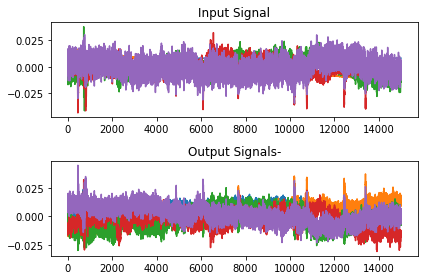

In [12]:
#Open
plot_mixture_sources_predictions(reconstructed_open.T, S_open)

In [13]:
#Closed
S_closed = ica(reconstructed_closed.T, 250, 1e-9)
print(reconstructed_closed.T.shape)
print(S_closed.shape)

(5, 15000)
(5, 15000)


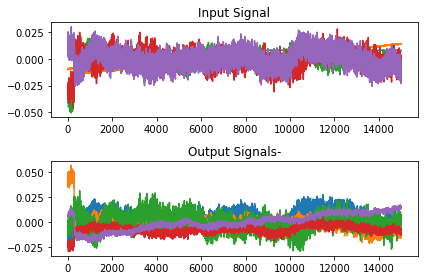

In [14]:
#Closed
plot_mixture_sources_predictions(reconstructed_closed.T, S_closed)

Reconstructed Channel 1 :
 [ 0.00198223  0.00301194  0.00121934 ... -0.00442867 -0.00330064
 -0.00302493]


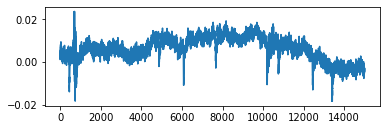

Reconstructed Channel 2 :
 [-0.01043465 -0.01039226 -0.00765832 ...  0.01187681  0.01581132
  0.01166866]


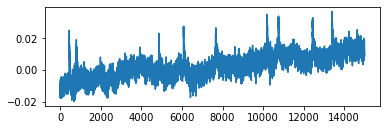

Reconstructed Channel 3 :
 [-0.00874305 -0.00558862 -0.00291901 ... -0.00414953  0.00227427
 -0.00173352]


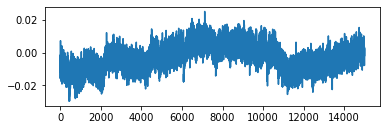

Reconstructed Channel 4 :
 [-0.01032354 -0.01056143 -0.01147858 ... -0.01683046 -0.0140823
 -0.01634803]


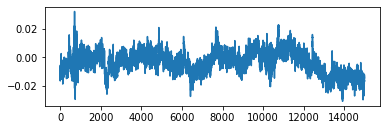

Reconstructed Channel 5 :
 [ 0.01237363  0.01343418  0.01775962 ... -0.00259578  0.00270662
 -0.00226417]


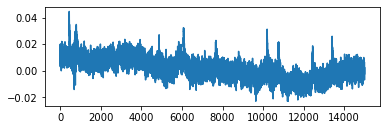

In [15]:
#Open
for i, s in enumerate(S_open):
    print("Reconstructed Channel", (i+1), ":\n", s)
    plt.subplot(2, 1, 2)
    plt.plot(s)
    plt.show()

Reconstructed Channel 1 :
 [-0.0111416  -0.01294677 -0.00326261 ... -0.00305226 -0.00552794
  0.00144282]


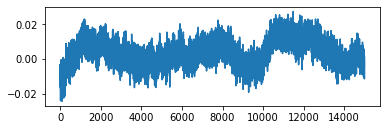

Reconstructed Channel 2 :
 [ 0.03918678  0.03648657  0.04541107 ... -0.0098608  -0.01284256
 -0.0051468 ]


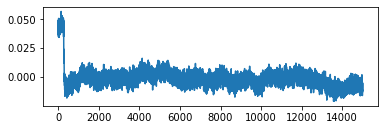

Reconstructed Channel 3 :
 [-0.00321597 -0.00032476 -0.00247388 ...  0.00079448  0.00559625
  0.00378575]


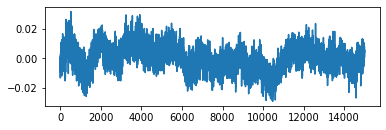

Reconstructed Channel 4 :
 [-0.02181334 -0.02219339 -0.01876204 ... -0.00889176 -0.00949633
 -0.00724436]


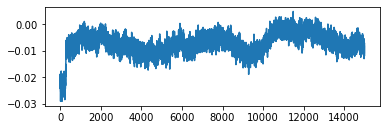

Reconstructed Channel 5 :
 [0.00547819 0.00552679 0.00614993 ... 0.01412674 0.01487376 0.01576236]


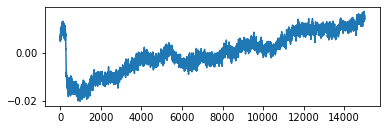

In [16]:
#Open
for i, s in enumerate(S_closed):
    print("Reconstructed Channel", (i+1), ":\n", s)
    plt.subplot(2, 1, 2)
    plt.plot(s)
    plt.show()